# TensorFlow 2.0 alpha - Train a Logistic Regression Model with Estimators
### Titanic Dataset

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

## Load the Titanic Dataset

In [2]:
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc

dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Explore Data

In [3]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [4]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [5]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

#### 627 passengers in the training set, 264 passengers in the evaluation set

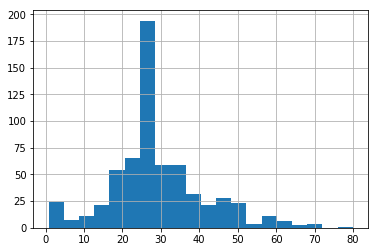

In [6]:
dftrain.age.hist(bins=20)

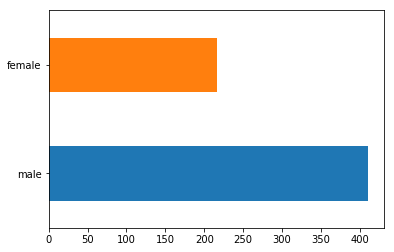

In [8]:
dftrain.sex.value_counts().plot(kind='barh')

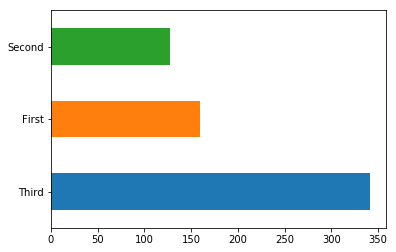

In [10]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5,0,'% survived')

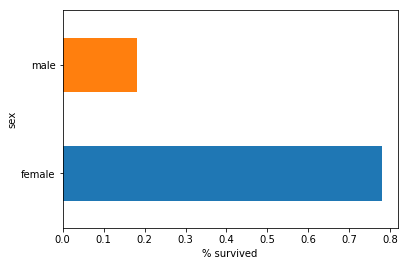

In [11]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived')

#### There are more males than females - most people are of the Third class - most people were in their 20s or 30s - females have a much higher survival probability

## Feature Engineering 
#### Estimators use Feature Columns to tell the model how to interpret the input features - Estimators expect vectors of numeric input, Feature columns tell the model how to Convert each feature (one-hot encoding , normalization, bucketization)

## Base Feature Columns

In [12]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                      'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []

for feature_name in CATEGORICAL_COLUMNS :
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS :
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

### Input Function 
#### Specifies how data is converted to a tf.data.Dataset - that feeds the input Pipeline in a streaming fashion

In [13]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32) :
    def input_function() :
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle :
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

## Inspect Dataset

In [14]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()

for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:' , list(feature_batch.keys()))
    print()
    print('A batch of class:', feature_batch['class'].numpy())
    print()
    print('A batch of labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Second' b'First' b'Third' b'Third' b'Third' b'Third' b'First' b'First'
 b'Third' b'Third']

A batch of labels: [0 1 0 0 0 0 0 0 1 0]


### Inspect result of a specific Feature Column using a .DenseFeatures layer

In [15]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

W0410 01:46:27.987637 140736985473984 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:2758: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


array([[51.],
       [42.],
       [23.],
       [36.],
       [28.],
       [28.],
       [24.],
       [47.],
       [32.],
       [28.]], dtype=float32)

### Categorical columns need to be converted to Indicator Columns, prior to a similar inspection - DenseFeatures only accepts dense tensors

In [16]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

W0410 01:49:44.466916 140736985473984 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/lookup_ops.py:1347: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0410 01:49:44.474554 140736985473984 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4307: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0410 01:49:44.475298 140736985473984 deprecation.py:323] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/feature_column/feature_column_v2.py:4362: VocabularyListCategoricalColumn._num_buckets (from tensorflow.python.feature_column.feature_column_v2) is depre

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Train Model
#### After adding Base Features, train using tf.estimator

In [17]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)

result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7348485, 'accuracy_baseline': 0.625, 'auc': 0.7801347, 'auc_precision_recall': 0.7252129, 'average_loss': 0.6093241, 'label/mean': 0.375, 'loss': 0.59961724, 'precision': 0.73770493, 'prediction/mean': 0.24539433, 'recall': 0.45454547, 'global_step': 200}


## Derived Feature Columns
#### Learn the differences between different Feature Combinations - Add Crossed Feature Columns to the model

In [18]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

#### Add the Combination Feature - Train model again

In [19]:
derived_feature_columns = [age_x_gender]

linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)

result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.8424854, 'auc_precision_recall': 0.78317213, 'average_loss': 0.48673698, 'label/mean': 0.375, 'loss': 0.48075187, 'precision': 0.64912283, 'prediction/mean': 0.440597, 'recall': 0.74747473, 'global_step': 200}


#### Now, accuracy of 75.38 % is achieved (over the previous 73.48 % with base features) - Additional features and transformations could be added to try for improvement

## Train Model for Predictions on Evaluation Set

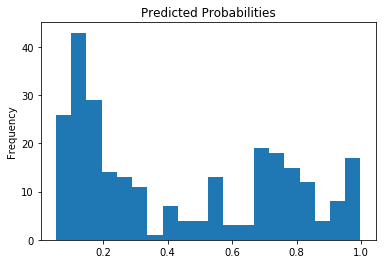

In [21]:
pred_dicts = list(linear_est.predict(eval_input_fn))

probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='Predicted Probabilities')

## View the Receiver Operating Characteristics - ROC of the results
#### Provides idea of the True Positive-False Positive tradeoff

(0, 1.05)

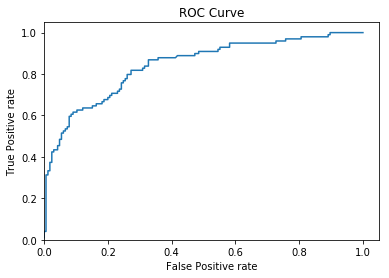

In [23]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.ylim(0, )
plt.xlim(0, )